___
# Exercice 2
___

Perform a simulation study to investigate the effect of penalized and unpenalized procedures seen throughout the semester, on the estimation of regression coefficients. Consider the linear model:   $$Y = x^T\beta + \epsilon$$
with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and correlated predictors $x \sim \mathcal{N}(0, \Sigma)$ where $\Sigma$ is a covariance matrix with the value 1 on the diagonal and the constant value $\rho$ for all off-diagonal values. 

In this exercise we will work with two different values for $\rho$ i.e. $\rho = 0.2$ and $0.7$. The vector $\beta$ (of length p) is of the form:    $\beta = (\beta_1, \beta_2, \beta_3, \beta_4, \beta_5, 0, \cdots, 0)^T$.

You are free to choose $\beta_1, \cdots, \beta_5$ and σ such that you distinguish between a low and high SNR = $\frac{Var(f(x))}{Var(\epsilon)}$

Simulate repeatedly (M=1000 repetitions) training and test datasets of size n = 15 and 100 (low sample size vs. high sample size) exhibiting low/high correlation and low/high SNR, from the regression model where p = 10 and 150 (low vs. high-dimensional).
Report on

(i) the accuracy of prediction on the test dataset, <br>
(ii) how well the active set is recovered (average TPR, FPR and FDR),<br>
(iii) how close the estimated values $\hat{\beta}$ are to the true $\beta$ used to generate the data.


___
### Imports and Function Definitions
___

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")

style.use('ggplot')

np.random.seed(0)

In [3]:
# Functions to create dataset

def create_X(n, p, rho):
    """
    Create a design matrix with a given correlation rho
    """
    sigma = np.ones((p, p)) * rho + np.identity(p) * (1 - rho)
    X = np.random.multivariate_normal(np.zeros(p), sigma, n)
    X = np.reshape(X, (n, p))
    return X



def create_y(X, beta, var_noise):
    """
    Create a vector of responses
    """
    n, p = X.shape
    y = np.zeros(n)
    y = np.dot(X, beta) + np.random.normal(0, np.sqrt(var_noise), n)
    return y


# Define different penalized and unpenalized models to test

def lm(X, y):
    """
    Unpenalized linear regression
    """
    model = LinearRegression().fit(X, y)
    return model

def ridge(X, y, alpha):
    """
    Ridge regression
    """
    model = Ridge(alpha=alpha).fit(X, y)
    return model

def lasso(X, y, alpha):
    """
    Lasso regression
    """
    model = Lasso(alpha=alpha).fit(X, y)
    return model

def elastic_net(X, y, alpha, l1_ratio):
    """
    Elastic net regression
    """
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X, y)
    return model

# Define function to compute scores

def scores(X_train, y_train, X_test, y_test, model, betas):   
    train_mse = np.mean((y_train - model.predict(X_train))**2)
    test_mse = np.mean((y_test - model.predict(X_test))**2)

    active = set(np.where(model.coef_ != 0)[0])
    inactive = set(np.where(model.coef_ == 0)[0])
    true_active = set(np.where(betas != 0)[0])
    true_inactive = set(np.where(betas == 0)[0])

    TP = len(active & true_active)
    FP = len(active & true_inactive)
    FN = len(inactive & true_active)
    TN = len(inactive & true_inactive)

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FDR = FP / (FP + TP) if FP + TP > 0 else 0

    betas_error = np.mean((model.coef_ - betas)**2)

    return train_mse, test_mse, TPR, FPR, FDR, betas_error

___
### Experiments
___

### Correlation ($\rho$) Experiment

- $M=1000$
- $n = 100$
- $p = 10$
- $\sigma^2 = 0.1$
- $\beta_{1:5}=1$

  0%|          | 0/1600 [00:00<?, ?it/s]

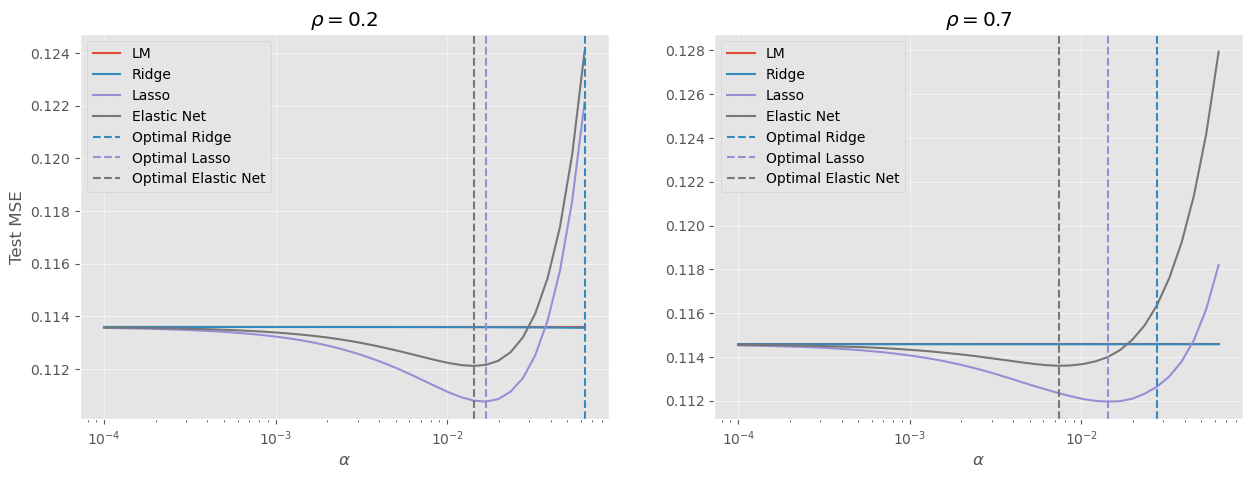

  0%|          | 0/2000 [00:00<?, ?it/s]

In [4]:
M=1000
n=100
p=10
var_noise=0.1
betas = np.zeros(p)
betas[:5] = 1

# Find optimal alpha for each model

alphas = [np.logspace(-4, -1.2, 40), np.logspace(-4, -1.2, 40)]
N = 20

lm_test_mse = np.zeros((2, len(alphas[0])))
ridge_test_mse = np.zeros((2, len(alphas[0])))
lasso_test_mse = np.zeros((2, len(alphas[0])))
elastic_net_test_mse = np.zeros((2, len(alphas[0])))

progress_bar = tqdm(range(N*2*len(alphas[0])))
for _ in range(N):
    for i, rho in enumerate([0.2, 0.7]):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        for j, alpha in enumerate(alphas[i]):
            lm_model = lm(X_train, y_train)
            ridge_model = ridge(X_train, y_train, alpha)
            lasso_model = lasso(X_train, y_train, alpha)
            elastic_net_model = elastic_net(X_train, y_train, alpha, 0.5)

            lm_test_mse[i, j] += np.mean((y_test - lm_model.predict(X_test))**2)
            ridge_test_mse[i, j] += np.mean((y_test - ridge_model.predict(X_test))**2)
            lasso_test_mse[i, j] += np.mean((y_test - lasso_model.predict(X_test))**2)
            elastic_net_test_mse[i, j] += np.mean((y_test - elastic_net_model.predict(X_test))**2)
            progress_bar.update(1)

lm_test_mse /= N
ridge_test_mse /= N
lasso_test_mse /= N
elastic_net_test_mse /= N

# Plot optimal alpha

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(alphas[0], lm_test_mse[0], label="LM")
ax[0].plot(alphas[0], ridge_test_mse[0], label="Ridge")
ax[0].plot(alphas[0], lasso_test_mse[0], label="Lasso")
ax[0].plot(alphas[0], elastic_net_test_mse[0], label="Elastic Net")
# plot optimal alpha
ax[0].axvline(alphas[0][np.argmin(ridge_test_mse[0])], color="C1", linestyle="--", label="Optimal Ridge")
ax[0].axvline(alphas[0][np.argmin(lasso_test_mse[0])], color="C2", linestyle="--", label="Optimal Lasso")
ax[0].axvline(alphas[0][np.argmin(elastic_net_test_mse[0])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Test MSE")
ax[0].set_title(r"$\rho = 0.2$")
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(alphas[1], lm_test_mse[1], label="LM")
ax[1].plot(alphas[1], ridge_test_mse[1], label="Ridge")
ax[1].plot(alphas[1], lasso_test_mse[1], label="Lasso")
ax[1].plot(alphas[1], elastic_net_test_mse[1], label="Elastic Net")
# plot optimal alpha
ax[1].axvline(alphas[1][np.argmin(ridge_test_mse[1])], color="C1", linestyle="--", label="Optimal Ridge")
ax[1].axvline(alphas[1][np.argmin(lasso_test_mse[1])], color="C2", linestyle="--", label="Optimal Lasso")
ax[1].axvline(alphas[1][np.argmin(elastic_net_test_mse[1])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_title(r"$\rho = 0.7$")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig("./ResultsEx2/optimal_alpha_rho.pdf")
plt.show()

# Choose optimal alpha and train models M times

alpha_lm_02 = alphas[0][np.argmin(lm_test_mse[0])]
alpha_ridge_02 = alphas[0][np.argmin(ridge_test_mse[0])]
alpha_lasso_02 = alphas[0][np.argmin(lasso_test_mse[0])]
alpha_elastic_net_02 = alphas[0][np.argmin(elastic_net_test_mse[0])]
alpha_lm_07 = alphas[1][np.argmin(lm_test_mse[1])]
alpha_ridge_07 = alphas[1][np.argmin(ridge_test_mse[1])]
alpha_lasso_07 = alphas[1][np.argmin(lasso_test_mse[1])]
alpha_elastic_net_07 = alphas[1][np.argmin(elastic_net_test_mse[1])]

lm_scores = np.zeros((2, M, 6))
ridge_scores = np.zeros((2, M, 6))
lasso_scores = np.zeros((2, M, 6))
elastic_net_scores = np.zeros((2, M, 6))

progress_bar = tqdm(range(M*2))

for i, rho in enumerate([0.2, 0.7]):
    for j in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        lm_model = lm(X_train, y_train)
        ridge_model = ridge(X_train, y_train, alpha_ridge_02 if i == 0 else alpha_ridge_07)
        lasso_model = lasso(X_train, y_train, alpha_lasso_02 if i == 0 else alpha_lasso_07)
        elastic_net_model = elastic_net(X_train, y_train, alpha_elastic_net_02 if i == 0 else alpha_elastic_net_07, 0.5)

        lm_scores[i, j] = scores(X_train, y_train, X_test, y_test, lm_model, betas)
        ridge_scores[i, j] = scores(X_train, y_train, X_test, y_test, ridge_model, betas)
        lasso_scores[i, j] = scores(X_train, y_train, X_test, y_test, lasso_model, betas)
        elastic_net_scores[i, j] = scores(X_train, y_train, X_test, y_test, elastic_net_model, betas)

        progress_bar.update(1)

# Save scores
        
np.save("./ResultsEx2/lm_scores_rho.npy", lm_scores)
np.save("./ResultsEx2/ridge_scores_rho.npy", ridge_scores)
np.save("./ResultsEx2/lasso_scores_rho.npy", lasso_scores)
np.save("./ResultsEx2/elastic_net_scores_rho.npy", elastic_net_scores)
        

#### Variance of Noise ($\sigma$) Experiment

- $M=1000$
- $n = 100$
- $p = 10$
- $\rho = 0.2$
- $\beta_{1:5}=1$


  0%|          | 0/1600 [00:00<?, ?it/s]

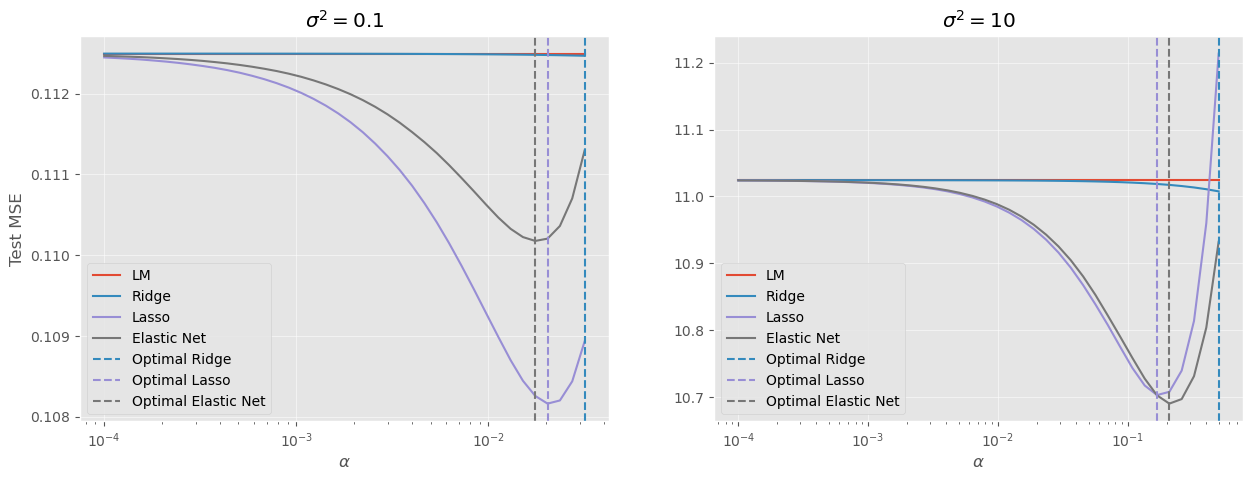

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
M=1000
n=100
p=10
rho=0.2
betas = np.zeros(p)
betas[:5] = 1

# Find optimal alpha for each model

alphas = [np.logspace(-4, -1.5, 40), np.logspace(-4, -0.3, 40)]
N = 20

lm_test_mse = np.zeros((2, len(alphas[0])))
ridge_test_mse = np.zeros((2, len(alphas[0])))
lasso_test_mse = np.zeros((2, len(alphas[0])))
elastic_net_test_mse = np.zeros((2, len(alphas[0])))

progress_bar = tqdm(range(N*2*len(alphas[0])))
for _ in range(N):
    for i, var_noise in enumerate([0.1, 10]):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        for j, alpha in enumerate(alphas[i]):
            lm_model = lm(X_train, y_train)
            ridge_model = ridge(X_train, y_train, alpha)
            lasso_model = lasso(X_train, y_train, alpha)
            elastic_net_model = elastic_net(X_train, y_train, alpha, 0.5)

            lm_test_mse[i, j] += np.mean((y_test - lm_model.predict(X_test))**2)
            ridge_test_mse[i, j] += np.mean((y_test - ridge_model.predict(X_test))**2)
            lasso_test_mse[i, j] += np.mean((y_test - lasso_model.predict(X_test))**2)
            elastic_net_test_mse[i, j] += np.mean((y_test - elastic_net_model.predict(X_test))**2)
            progress_bar.update(1)

lm_test_mse /= N
ridge_test_mse /= N
lasso_test_mse /= N
elastic_net_test_mse /= N

# Plot optimal alpha

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(alphas[0], lm_test_mse[0], label="LM")
ax[0].plot(alphas[0], ridge_test_mse[0], label="Ridge")
ax[0].plot(alphas[0], lasso_test_mse[0], label="Lasso")
ax[0].plot(alphas[0], elastic_net_test_mse[0], label="Elastic Net")
ax[0].axvline(alphas[0][np.argmin(ridge_test_mse[0])], color="C1", linestyle="--", label="Optimal Ridge")
ax[0].axvline(alphas[0][np.argmin(lasso_test_mse[0])], color="C2", linestyle="--", label="Optimal Lasso")
ax[0].axvline(alphas[0][np.argmin(elastic_net_test_mse[0])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Test MSE")
ax[0].set_title(r"$\sigma^2 = 0.1$")
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(alphas[1], lm_test_mse[1], label="LM")
ax[1].plot(alphas[1], ridge_test_mse[1], label="Ridge")
ax[1].plot(alphas[1], lasso_test_mse[1], label="Lasso")
ax[1].plot(alphas[1], elastic_net_test_mse[1], label="Elastic Net")
ax[1].axvline(alphas[1][np.argmin(ridge_test_mse[1])], color="C1", linestyle="--", label="Optimal Ridge")
ax[1].axvline(alphas[1][np.argmin(lasso_test_mse[1])], color="C2", linestyle="--", label="Optimal Lasso")
ax[1].axvline(alphas[1][np.argmin(elastic_net_test_mse[1])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_title(r"$\sigma^2 = 10$")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig("./ResultsEx2/optimal_alpha_var_noise.pdf")
plt.show()

# Choose optimal alpha and train models M times

alpha_ridge_01 = alphas[0][np.argmin(ridge_test_mse[0])]
alpha_lasso_01 = alphas[0][np.argmin(lasso_test_mse[0])]
alpha_elastic_net_01 = alphas[0][np.argmin(elastic_net_test_mse[0])]
alpha_ridge_10 = alphas[1][np.argmin(ridge_test_mse[1])]
alpha_lasso_10 = alphas[1][np.argmin(lasso_test_mse[1])]
alpha_elastic_net_10 = alphas[1][np.argmin(elastic_net_test_mse[1])]

lm_scores = np.zeros((2, M, 6))
ridge_scores = np.zeros((2, M, 6))
lasso_scores = np.zeros((2, M, 6))
elastic_net_scores = np.zeros((2, M, 6))

progress_bar = tqdm(range(M*2))

for i, var_noise in enumerate([0.1, 10]):
    for j in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        lm_model = lm(X_train, y_train)
        ridge_model = ridge(X_train, y_train, alpha_ridge_01 if i == 0 else alpha_ridge_10)
        lasso_model = lasso(X_train, y_train, alpha_lasso_01 if i == 0 else alpha_lasso_10)
        elastic_net_model = elastic_net(X_train, y_train, alpha_elastic_net_01 if i == 0 else alpha_elastic_net_10, 0.5)

        lm_scores[i, j] = scores(X_train, y_train, X_test, y_test, lm_model, betas)
        ridge_scores[i, j] = scores(X_train, y_train, X_test, y_test, ridge_model, betas)
        lasso_scores[i, j] = scores(X_train, y_train, X_test, y_test, lasso_model, betas)
        elastic_net_scores[i, j] = scores(X_train, y_train, X_test, y_test, elastic_net_model, betas)

        progress_bar.update(1)

# Save scores
        
np.save("./ResultsEx2/lm_scores_var_noise.npy", lm_scores)
np.save("./ResultsEx2/ridge_scores_var_noise.npy", ridge_scores)
np.save("./ResultsEx2/lasso_scores_var_noise.npy", lasso_scores)
np.save("./ResultsEx2/elastic_net_scores_var_noise.npy", elastic_net_scores)

#### Sample Size ($n$) Experiment

- $M=1000$
- $p = 10$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$


  0%|          | 0/1600 [00:00<?, ?it/s]

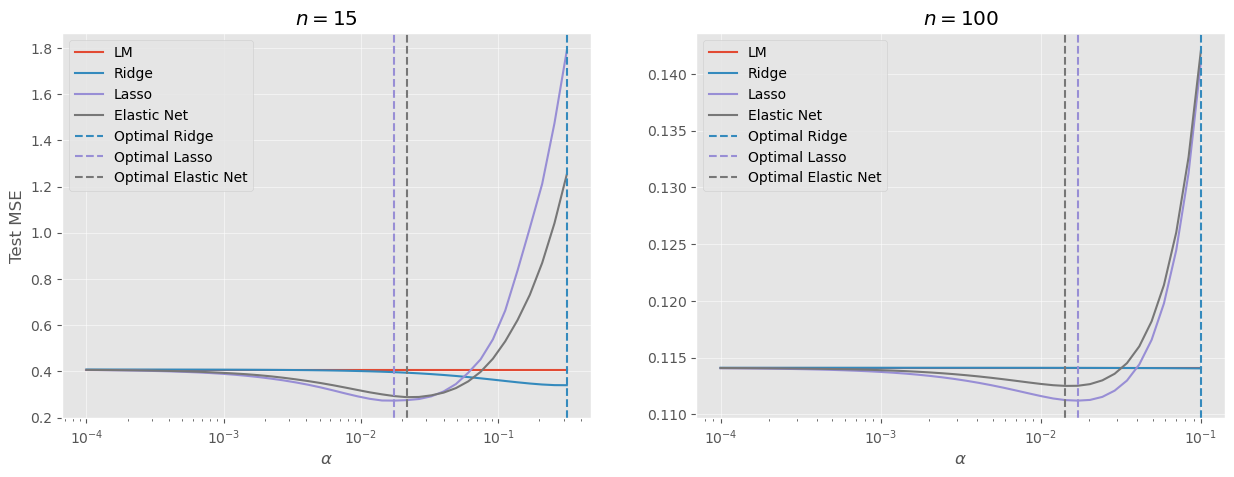

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
M=1000
p=10
rho=0.2
var_noise=0.1
betas = np.zeros(p)
betas[:5] = 1

# Find optimal alpha for each model

alphas = [np.logspace(-4, -0.5, 40), np.logspace(-4, -1, 40)]
N = 20

lm_test_mse = np.zeros((2, len(alphas[0])))
ridge_test_mse = np.zeros((2, len(alphas[0])))
lasso_test_mse = np.zeros((2, len(alphas[0])))
elastic_net_test_mse = np.zeros((2, len(alphas[0])))

progress_bar = tqdm(range(N*2*len(alphas[0])))
for _ in range(N):
    for i, n in enumerate([15, 100]):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        for j, alpha in enumerate(alphas[i]):
            lm_model = lm(X_train, y_train)
            ridge_model = ridge(X_train, y_train, alpha)
            lasso_model = lasso(X_train, y_train, alpha)
            elastic_net_model = elastic_net(X_train, y_train, alpha, 0.5)

            lm_test_mse[i, j] += np.mean((y_test - lm_model.predict(X_test))**2)
            ridge_test_mse[i, j] += np.mean((y_test - ridge_model.predict(X_test))**2)
            lasso_test_mse[i, j] += np.mean((y_test - lasso_model.predict(X_test))**2)
            elastic_net_test_mse[i, j] += np.mean((y_test - elastic_net_model.predict(X_test))**2)
            progress_bar.update(1)

lm_test_mse /= N
ridge_test_mse /= N
lasso_test_mse /= N
elastic_net_test_mse /= N

# Plot optimal alpha

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(alphas[0], lm_test_mse[0], label="LM")
ax[0].plot(alphas[0], ridge_test_mse[0], label="Ridge")
ax[0].plot(alphas[0], lasso_test_mse[0], label="Lasso")
ax[0].plot(alphas[0], elastic_net_test_mse[0], label="Elastic Net")
ax[0].axvline(alphas[0][np.argmin(ridge_test_mse[0])], color="C1", linestyle="--", label="Optimal Ridge")
ax[0].axvline(alphas[0][np.argmin(lasso_test_mse[0])], color="C2", linestyle="--", label="Optimal Lasso")
ax[0].axvline(alphas[0][np.argmin(elastic_net_test_mse[0])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Test MSE")
ax[0].set_title(r"$n = 15$")
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(alphas[1], lm_test_mse[1], label="LM")
ax[1].plot(alphas[1], ridge_test_mse[1], label="Ridge")
ax[1].plot(alphas[1], lasso_test_mse[1], label="Lasso")
ax[1].plot(alphas[1], elastic_net_test_mse[1], label="Elastic Net")
ax[1].axvline(alphas[1][np.argmin(ridge_test_mse[1])], color="C1", linestyle="--", label="Optimal Ridge")
ax[1].axvline(alphas[1][np.argmin(lasso_test_mse[1])], color="C2", linestyle="--", label="Optimal Lasso")
ax[1].axvline(alphas[1][np.argmin(elastic_net_test_mse[1])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_title(r"$n = 100$")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig("./ResultsEx2/optimal_alpha_n.pdf")
plt.show()

# Choose optimal alpha and train models M times

alpha_ridge_01 = alphas[0][np.argmin(ridge_test_mse[0])]
alpha_lasso_01 = alphas[0][np.argmin(lasso_test_mse[0])]
alpha_elastic_net_01 = alphas[0][np.argmin(elastic_net_test_mse[0])]
alpha_ridge_10 = alphas[1][np.argmin(ridge_test_mse[1])]
alpha_lasso_10 = alphas[1][np.argmin(lasso_test_mse[1])]
alpha_elastic_net_10 = alphas[1][np.argmin(elastic_net_test_mse[1])]

lm_scores = np.zeros((2, M, 6))
ridge_scores = np.zeros((2, M, 6))
lasso_scores = np.zeros((2, M, 6))
elastic_net_scores = np.zeros((2, M, 6))

progress_bar = tqdm(range(M*2))

for i, n in enumerate([15, 100]):
    for j in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        lm_model = lm(X_train, y_train)
        ridge_model = ridge(X_train, y_train, alpha_ridge_01 if i == 0 else alpha_ridge_10)
        lasso_model = lasso(X_train, y_train, alpha_lasso_01 if i == 0 else alpha_lasso_10)
        elastic_net_model = elastic_net(X_train, y_train, alpha_elastic_net_01 if i == 0 else alpha_elastic_net_10, 0.5)

        lm_scores[i, j] = scores(X_train, y_train, X_test, y_test, lm_model, betas)
        ridge_scores[i, j] = scores(X_train, y_train, X_test, y_test, ridge_model, betas)
        lasso_scores[i, j] = scores(X_train, y_train, X_test, y_test, lasso_model, betas)
        elastic_net_scores[i, j] = scores(X_train, y_train, X_test, y_test, elastic_net_model, betas)

        progress_bar.update(1)

# Save scores
        
np.save("./ResultsEx2/lm_scores_n.npy", lm_scores)
np.save("./ResultsEx2/ridge_scores_n.npy", ridge_scores)
np.save("./ResultsEx2/lasso_scores_n.npy", lasso_scores)
np.save("./ResultsEx2/elastic_net_scores_n.npy", elastic_net_scores)

#### Dimensionality ($p$) Experiment

- $M=1000$
- $n = 100$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$

  0%|          | 0/1000 [00:00<?, ?it/s]

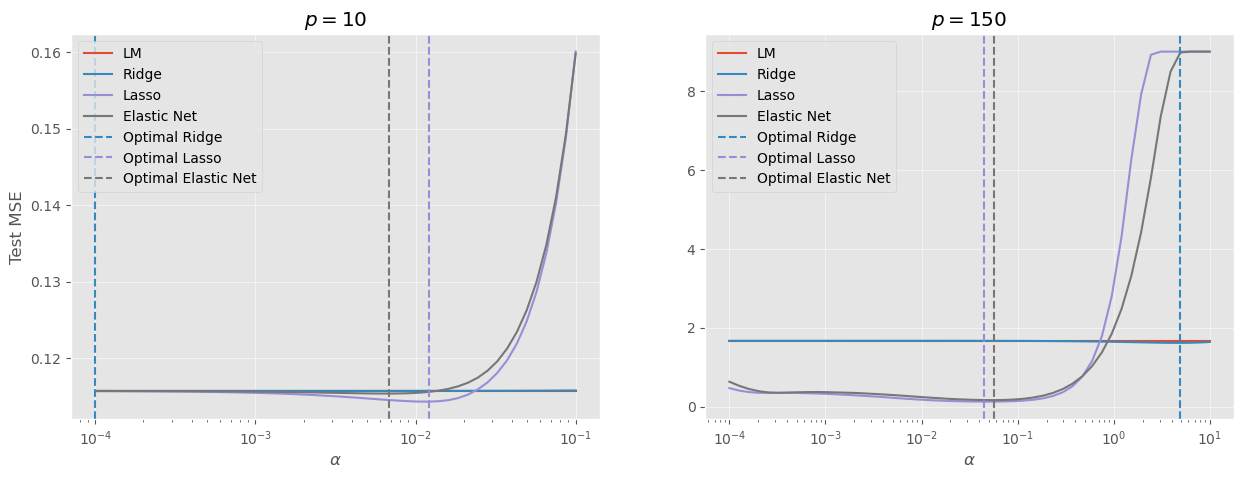

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
M=1000
n=100
var_noise=0.1
rho=0.2

# Find optimal alpha for each model

alphas = [np.logspace(-4, -1, 50), np.logspace(-4, 1, 50)]
N = 10

lm_test_mse = np.zeros((2, len(alphas[0])))
ridge_test_mse = np.zeros((2, len(alphas[0])))
lasso_test_mse = np.zeros((2, len(alphas[0])))
elastic_net_test_mse = np.zeros((2, len(alphas[0])))

progress_bar = tqdm(range(N*2*len(alphas[0])))
for _ in range(N):
    for i, p in enumerate([10, 150]):
        betas = np.zeros(p)
        betas[:5] = 1

        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        for j, alpha in enumerate(alphas[i]):
            lm_model = lm(X_train, y_train)
            ridge_model = ridge(X_train, y_train, alpha)
            lasso_model = lasso(X_train, y_train, alpha)
            elastic_net_model = elastic_net(X_train, y_train, alpha, 0.5)

            lm_test_mse[i, j] += np.mean((y_test - lm_model.predict(X_test))**2)
            ridge_test_mse[i, j] += np.mean((y_test - ridge_model.predict(X_test))**2)
            lasso_test_mse[i, j] += np.mean((y_test - lasso_model.predict(X_test))**2)
            elastic_net_test_mse[i, j] += np.mean((y_test - elastic_net_model.predict(X_test))**2)
            progress_bar.update(1)

lm_test_mse /= N
ridge_test_mse /= N
lasso_test_mse /= N
elastic_net_test_mse /= N

# Plot optimal alpha

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(alphas[0], lm_test_mse[0], label="LM")
ax[0].plot(alphas[0], ridge_test_mse[0], label="Ridge")
ax[0].plot(alphas[0], lasso_test_mse[0], label="Lasso")
ax[0].plot(alphas[0], elastic_net_test_mse[0], label="Elastic Net")
ax[0].axvline(alphas[0][np.argmin(ridge_test_mse[0])], color="C1", linestyle="--", label="Optimal Ridge")
ax[0].axvline(alphas[0][np.argmin(lasso_test_mse[0])], color="C2", linestyle="--", label="Optimal Lasso")
ax[0].axvline(alphas[0][np.argmin(elastic_net_test_mse[0])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("Test MSE")
ax[0].set_title(r"$p = 10$")
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(alphas[1], lm_test_mse[1], label="LM")
ax[1].plot(alphas[1], ridge_test_mse[1], label="Ridge")
ax[1].plot(alphas[1], lasso_test_mse[1], label="Lasso")
ax[1].plot(alphas[1], elastic_net_test_mse[1], label="Elastic Net")
ax[1].axvline(alphas[1][np.argmin(ridge_test_mse[1])], color="C1", linestyle="--", label="Optimal Ridge")
ax[1].axvline(alphas[1][np.argmin(lasso_test_mse[1])], color="C2", linestyle="--", label="Optimal Lasso")
ax[1].axvline(alphas[1][np.argmin(elastic_net_test_mse[1])], color="C3", linestyle="--", label="Optimal Elastic Net")
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_title(r"$p = 150$")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig("./ResultsEx2/optimal_alpha_p.pdf")
plt.show()

# Choose optimal alpha and train models M times

alpha_ridge_01 = alphas[0][np.argmin(ridge_test_mse[0])]
alpha_lasso_01 = alphas[0][np.argmin(lasso_test_mse[0])]
alpha_elastic_net_01 = alphas[0][np.argmin(elastic_net_test_mse[0])]
alpha_ridge_10 = alphas[1][np.argmin(ridge_test_mse[1])]
alpha_lasso_10 = alphas[1][np.argmin(lasso_test_mse[1])]
alpha_elastic_net_10 = alphas[1][np.argmin(elastic_net_test_mse[1])]

lm_scores = np.zeros((2, M, 6))
ridge_scores = np.zeros((2, M, 6))
lasso_scores = np.zeros((2, M, 6))
elastic_net_scores = np.zeros((2, M, 6))

progress_bar = tqdm(range(M*2))

for i, p in enumerate([10, 150]):
    betas = np.zeros(p)
    betas[:5] = 1
    for j in range(M):
        X_train = create_X(n, p, rho)
        y_train = create_y(X_train, betas, var_noise)
        X_test = create_X(M, p, rho)
        y_test = create_y(X_test, betas, var_noise)
        lm_model = lm(X_train, y_train)
        ridge_model = ridge(X_train, y_train, alpha_ridge_01 if i == 0 else alpha_ridge_10)
        lasso_model = lasso(X_train, y_train, alpha_lasso_01 if i == 0 else alpha_lasso_10)
        elastic_net_model = elastic_net(X_train, y_train, alpha_elastic_net_01 if i == 0 else alpha_elastic_net_10, 0.5)

        lm_scores[i, j] = scores(X_train, y_train, X_test, y_test, lm_model, betas)
        ridge_scores[i, j] = scores(X_train, y_train, X_test, y_test, ridge_model, betas)
        lasso_scores[i, j] = scores(X_train, y_train, X_test, y_test, lasso_model, betas)
        elastic_net_scores[i, j] = scores(X_train, y_train, X_test, y_test, elastic_net_model, betas)

        progress_bar.update(1)

# Save scores
        
np.save("./ResultsEx2/lm_scores_p.npy", lm_scores)
np.save("./ResultsEx2/ridge_scores_p.npy", ridge_scores)
np.save("./ResultsEx2/lasso_scores_p.npy", lasso_scores)
np.save("./ResultsEx2/elastic_net_scores_p.npy", elastic_net_scores)

___
### Results
___

In [8]:
def show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, label, values, log_mse=False, log_beta=False):

    label_save = ''.join([i for i in label if i.isalpha()])

    M=1000

    lm_02_01 = lm_scores[0]
    lm_07_01 = lm_scores[1]
    ridge_02_01 = ridge_scores[0]
    ridge_07_01 = ridge_scores[1]
    lasso_02_01 = lasso_scores[0]
    lasso_07_01 = lasso_scores[1]
    elastic_net_02_01 = elastic_net_scores[0]
    elastic_net_07_01 = elastic_net_scores[1]

    models = ['lm', 'ridge', 'lasso', 'elastic_net']

    ### Plots MSE
    
    mse_02 = pd.DataFrame({
        'mse': np.concatenate((lm_02_01[:, 0], ridge_02_01[:, 0], lasso_02_01[:, 0], elastic_net_02_01[:, 0], 
                               lm_02_01[:, 1], ridge_02_01[:, 1], lasso_02_01[:, 1], elastic_net_02_01[:, 1])),
        'model': np.concatenate((['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M, ['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M)),
        'set': np.concatenate((['Train']*M, ['Train']*M, ['Train']*M, ['Train']*M, ['Test']*M, ['Test']*M, ['Test']*M, ['Test']*M))
    })

    mse_07 = pd.DataFrame({
        'mse': np.concatenate((lm_07_01[:, 0], ridge_07_01[:, 0], lasso_07_01[:, 0], elastic_net_07_01[:, 0],
                                 lm_07_01[:, 1], ridge_07_01[:, 1], lasso_07_01[:, 1], elastic_net_07_01[:, 1])),
        'model': np.concatenate((['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M, ['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M)),
        'set': np.concatenate((['Train']*M, ['Train']*M, ['Train']*M, ['Train']*M, ['Test']*M, ['Test']*M, ['Test']*M, ['Test']*M))
    })

    if log_mse:
        mse_02['mse'] = np.log(mse_02['mse'])
        mse_07['mse'] = np.log(mse_07['mse'])

    # boxplots with train and test mse for the 4 models

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

    b = sns.boxplot(x='model', y='mse', hue='set', data=mse_02, ax=ax1)
    ax1.set_title('{} = {}'.format(label, values[0]))
    ax1.set_ylabel(r'$\log(\mathbb{E}((Y - \hat{Y})^2))$' if log_mse else r'$\mathbb{E}((Y - \hat{Y})^2)$')
    ax1.set_xlabel('')
    ax1.legend([],[], frameon=False)

    sns.boxplot(x='model', y='mse', hue='set', data=mse_07, ax=ax2)
    ax2.set_title('{} = {}'.format(label, values[1]))
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    fig.tight_layout()
    plt.savefig('./Plots/mse_'+label_save+'.pdf', format='pdf')
    plt.show()

    ### Plots TPR, FPR and FDR

    ratios_02 = {'TPR': [lm_02_01[:,2].mean(), ridge_02_01[:,2].mean(), lasso_02_01[:,2].mean(), elastic_net_02_01[:,2].mean()],
                 'FPR': [lm_02_01[:,3].mean(), ridge_02_01[:,3].mean(), lasso_02_01[:,3].mean(), elastic_net_02_01[:,3].mean()],
                 'FDR': [lm_02_01[:,4].mean(), ridge_02_01[:,4].mean(), lasso_02_01[:,4].mean(), elastic_net_02_01[:,4].mean()]}
    
    ratios_07 = {'TPR': [lm_07_01[:,2].mean(), ridge_07_01[:,2].mean(), lasso_07_01[:,2].mean(), elastic_net_07_01[:,2].mean()],
                'FPR': [lm_07_01[:,3].mean(), ridge_07_01[:,3].mean(), lasso_07_01[:,3].mean(), elastic_net_07_01[:,3].mean()],
                'FDR': [lm_07_01[:,4].mean(), ridge_07_01[:,4].mean(), lasso_07_01[:,4].mean(), elastic_net_07_01[:,4].mean()]}

    x = np.arange(len(models))
    width = 0.2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    rects1 = ax1.bar(x - width, ratios_02['TPR'], width, label='TPR', alpha=0.8)
    rects2 = ax1.bar(x, ratios_02['FPR'], width, label='FPR', alpha=0.8)
    rects3 = ax1.bar(x + width, ratios_02['FDR'], width, label='FDR', alpha=0.8)

    ax1.set_ylabel('Ratios')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_title('{} = {}'.format(label, values[0]))

    rects1 = ax2.bar(x - width, ratios_07['TPR'], width, label='TPR', alpha=0.8)
    rects2 = ax2.bar(x, ratios_07['FPR'], width, label='FPR', alpha=0.8)
    rects3 = ax2.bar(x + width, ratios_07['FDR'], width, label='FDR', alpha=0.8)

    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax2.set_title('{} = {}'.format(label, values[1]))

    fig.tight_layout()
    plt.savefig('./Plots/ratios_'+label_save+'.pdf', format='pdf')
    plt.show()

    ### Plots betas error

    betas_error_02 = {
        'errors': np.concatenate((lm_02_01[:,5], ridge_02_01[:,5], lasso_02_01[:,5], elastic_net_02_01[:,5])),
        'model': np.concatenate((['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M)),
    }

    betas_error_07 = {
        'errors': np.concatenate((lm_07_01[:,5], ridge_07_01[:,5], lasso_07_01[:,5], elastic_net_07_01[:,5])),
        'model': np.concatenate((['lm']*M, ['ridge']*M, ['lasso']*M, ['elastic_net']*M)),
    }

    if log_beta:
        betas_error_02['errors'] = np.log(betas_error_02['errors'])
        betas_error_07['errors'] = np.log(betas_error_07['errors'])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

    sns.boxplot(x='model', y='errors', data=betas_error_02, ax=ax1)
    ax1.set_title('{} = {}'.format(label, values[0]))
    ax1.set_ylabel(r'$\mathbb{E}((\beta - \hat{\beta})^2)$' if not log_beta else r'$\log(\mathbb{E}((\beta - \hat{\beta})^2))$')
    ax1.set_xlabel('')

    sns.boxplot(x='model', y='errors', data=betas_error_07, ax=ax2)
    ax2.set_title('{} = {}'.format(label, values[1]))
    ax2.set_ylabel('')
    ax2.set_xlabel('')

    fig.tight_layout()
    # keep only letter in label
    
    plt.savefig('./Plots/betas_error_'+label_save+'.pdf', format='pdf')

    plt.show()


#### Correlation ($\rho$) Experiment Results

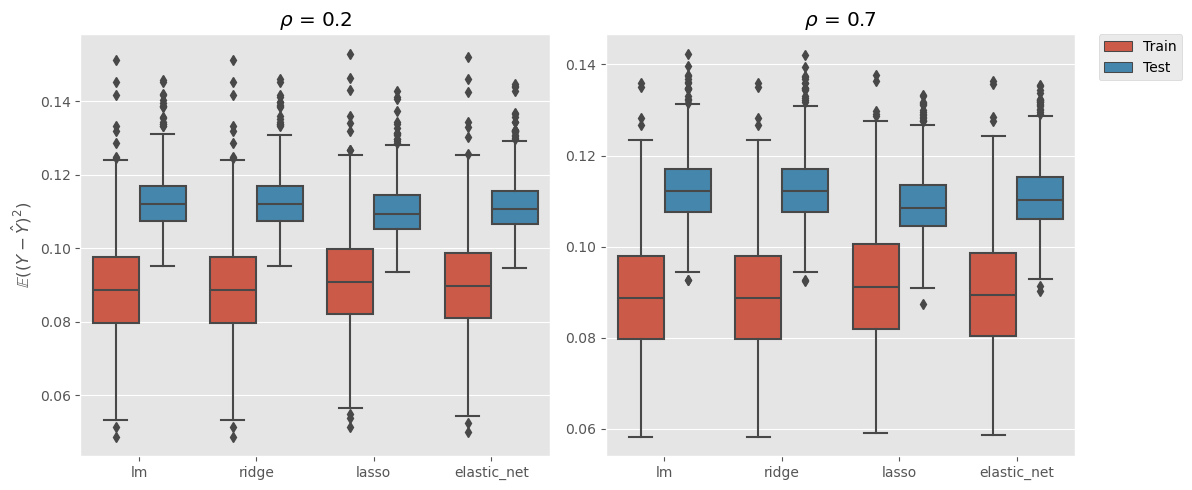

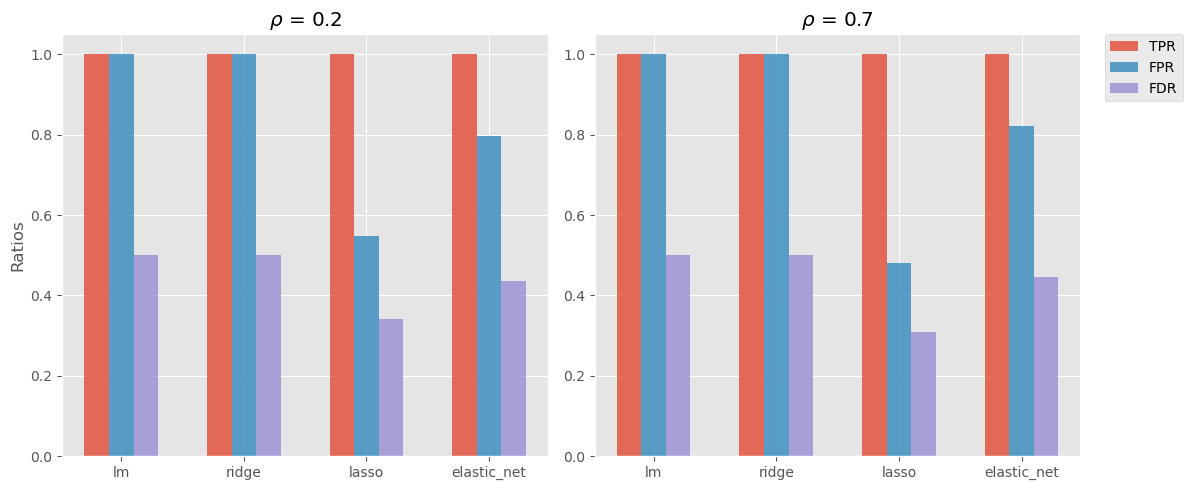

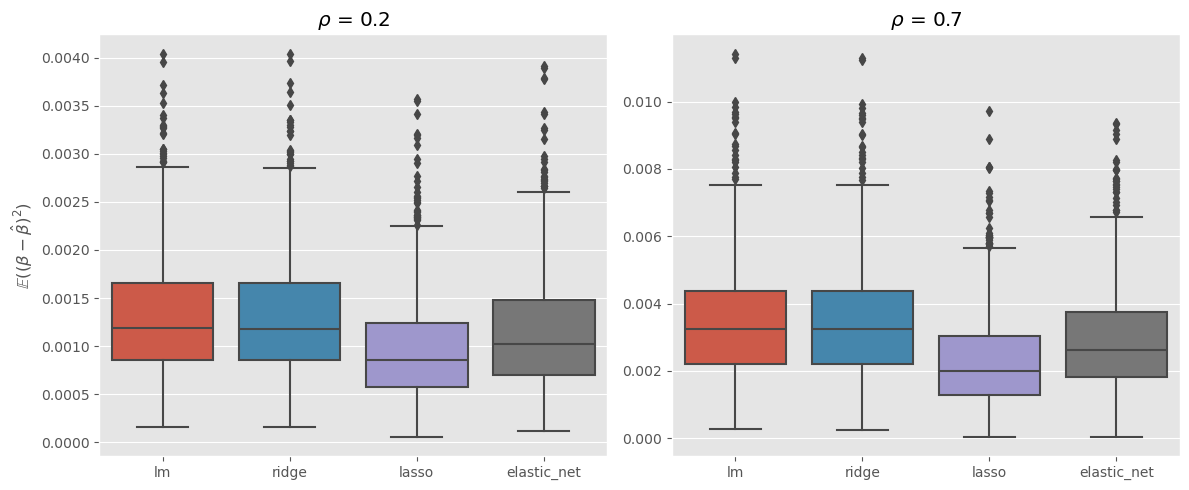

In [9]:
lm_scores = np.load("./ResultsEx2/lm_scores_rho.npy")
ridge_scores = np.load("./ResultsEx2/ridge_scores_rho.npy")
lasso_scores = np.load("./ResultsEx2/lasso_scores_rho.npy")
elastic_net_scores = np.load("./ResultsEx2/elastic_net_scores_rho.npy")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, r'$\rho$', [0.2, 0.7])

#### Variance of Noise ($\sigma$) Experiment Results

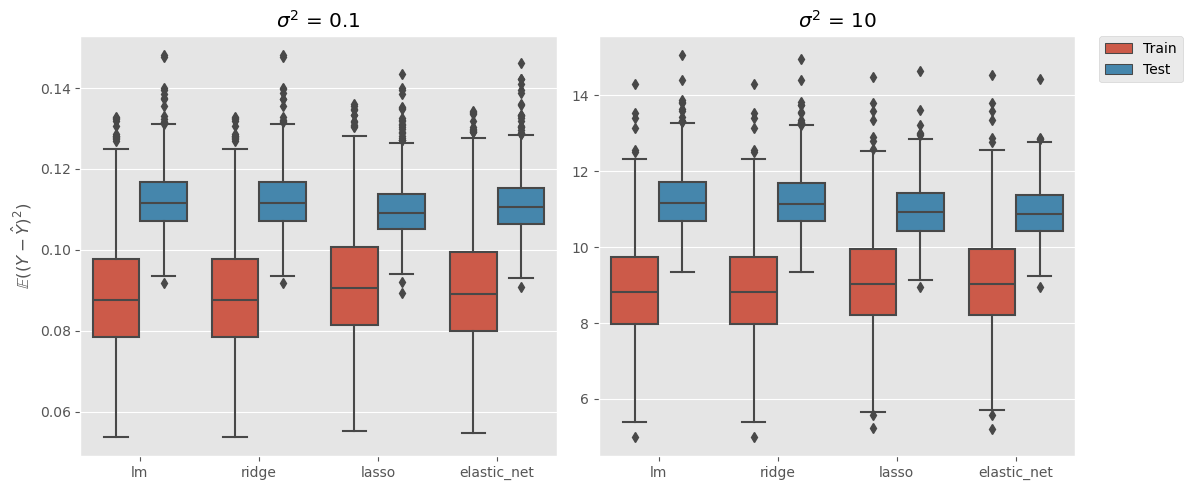

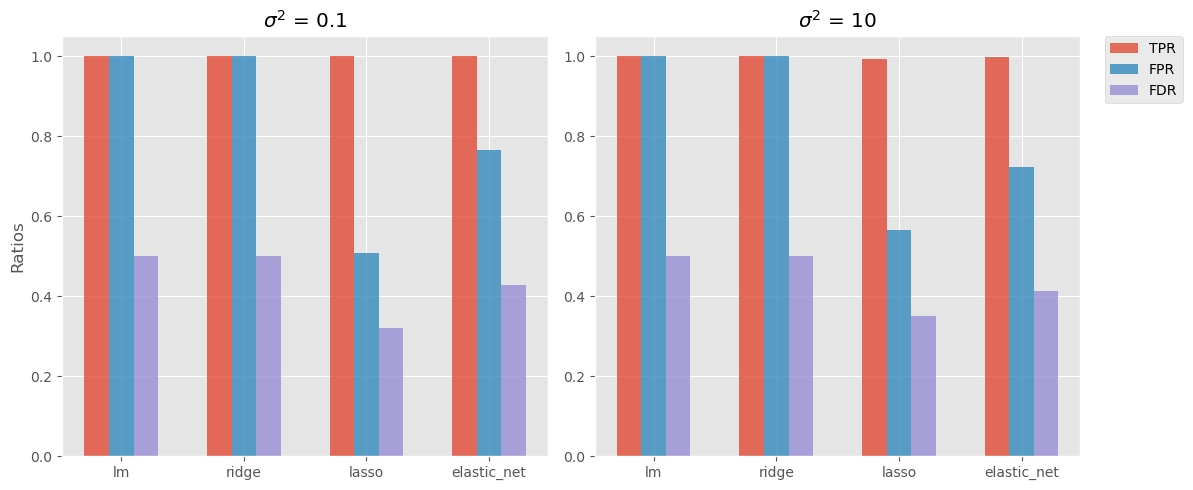

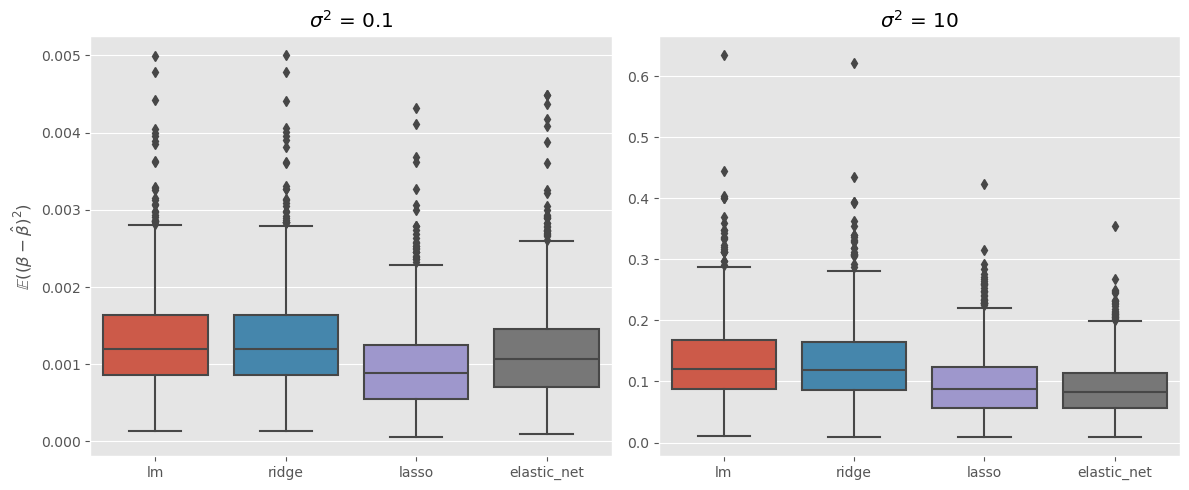

In [10]:
lm_scores = np.load("./ResultsEx2/lm_scores_var_noise.npy")
ridge_scores = np.load("./ResultsEx2/ridge_scores_var_noise.npy")
lasso_scores = np.load("./ResultsEx2/lasso_scores_var_noise.npy")
elastic_net_scores = np.load("./ResultsEx2/elastic_net_scores_var_noise.npy")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, r'$\sigma^2$', [0.1, 10])

#### Sample Size ($n$) Experiment Results

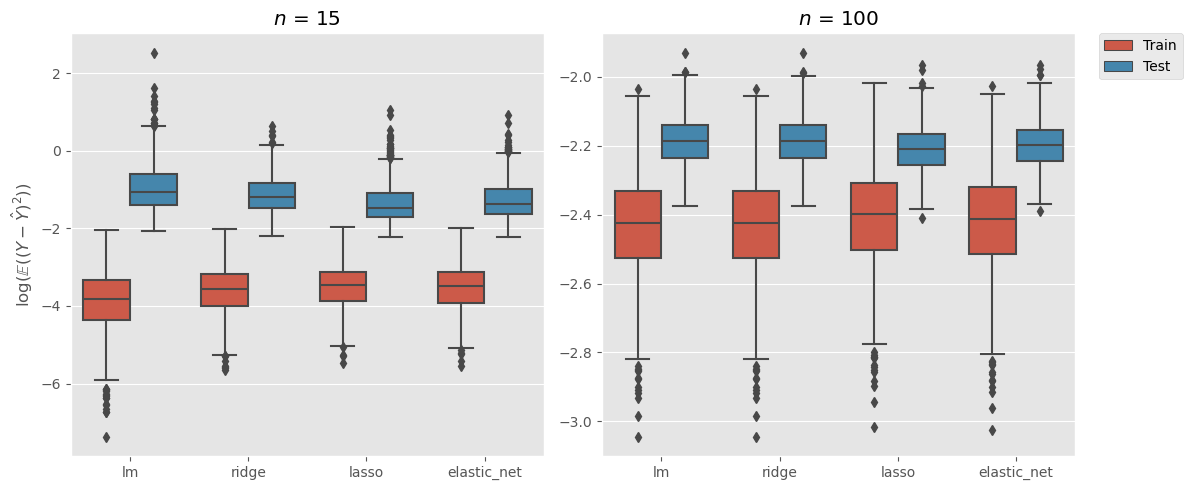

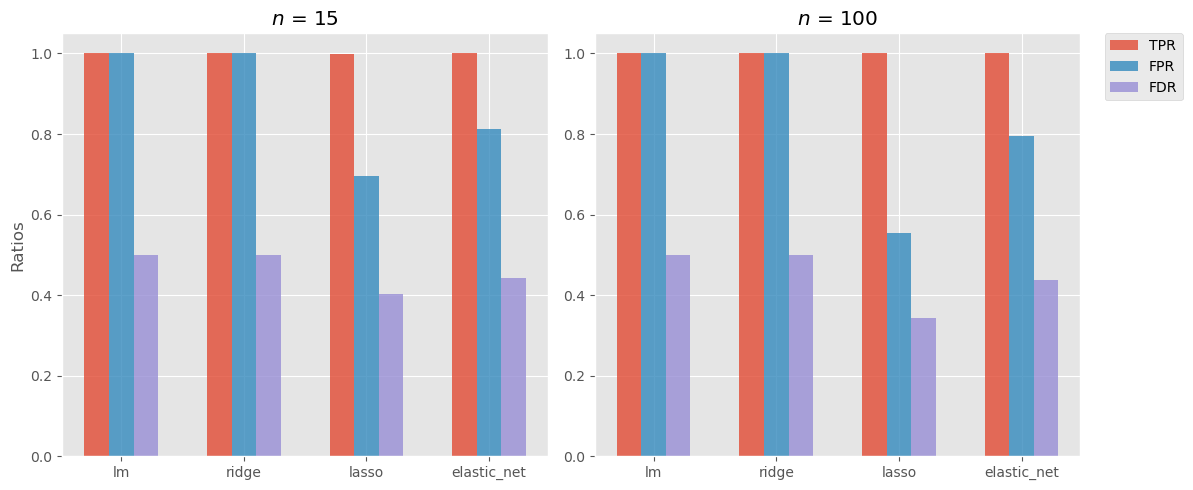

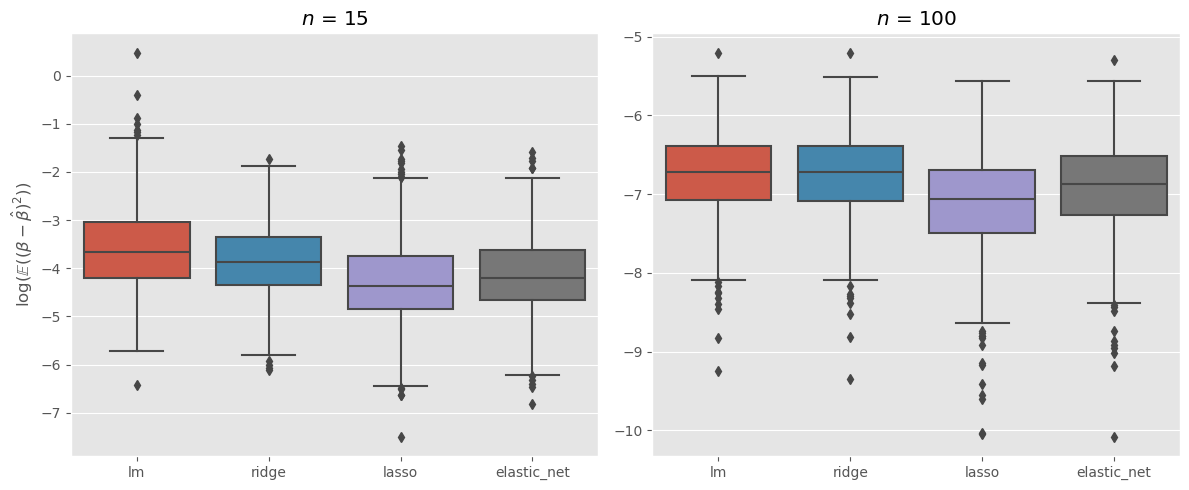

In [11]:
lm_scores = np.load("./ResultsEx2/lm_scores_n.npy")
ridge_scores = np.load("./ResultsEx2/ridge_scores_n.npy")
lasso_scores = np.load("./ResultsEx2/lasso_scores_n.npy")
elastic_net_scores = np.load("./ResultsEx2/elastic_net_scores_n.npy")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, r'$n$', [15, 100], log_mse=True, log_beta=True)

#### Dimensionality ($p$) Experiment Results

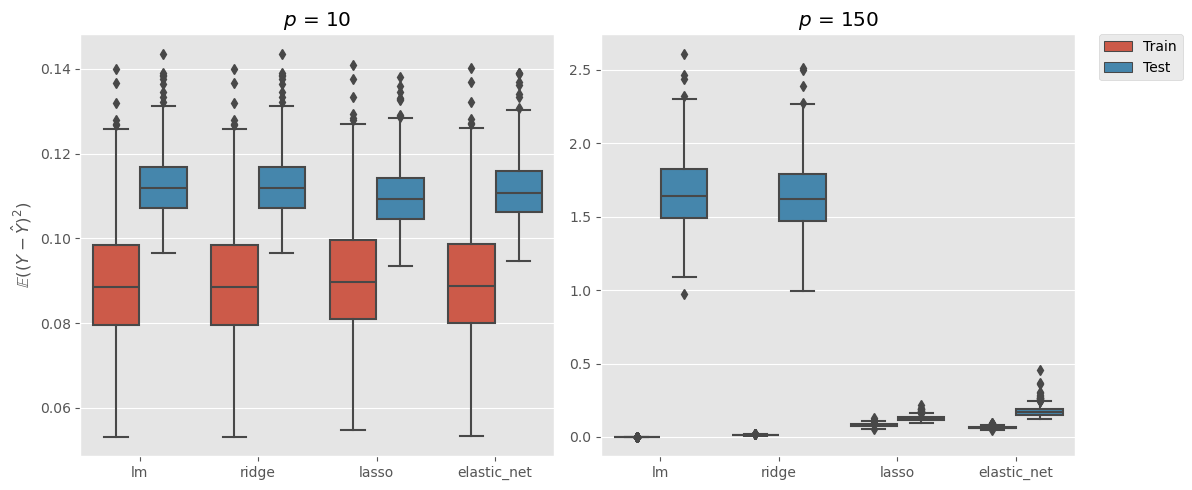

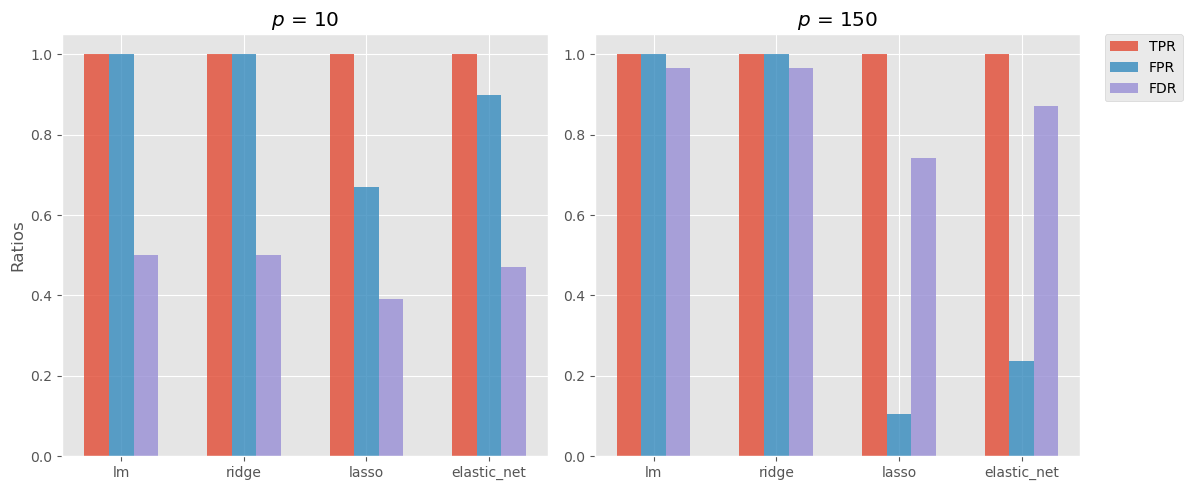

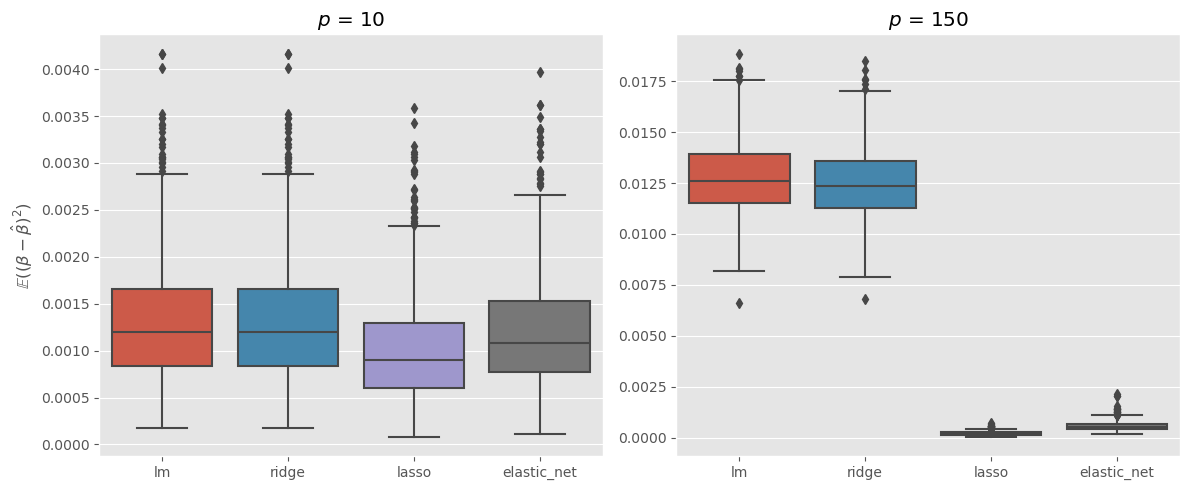

In [12]:
lm_scores = np.load("./ResultsEx2/lm_scores_p.npy")
ridge_scores = np.load("./ResultsEx2/ridge_scores_p.npy")
lasso_scores = np.load("./ResultsEx2/lasso_scores_p.npy")
elastic_net_scores = np.load("./ResultsEx2/elastic_net_scores_p.npy")

show_results(lm_scores, ridge_scores, lasso_scores, elastic_net_scores, r'$p$', [10, 150])